<a href="https://colab.research.google.com/github/SkdooshNB/rice-leaf-disease-detection/blob/master/potato_model0_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# API connectivity

In [ ]:
! pip install kaggle

In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
# mkdir plant_disease

In [ ]:
cd plant_disease/

/content/drive/MyDrive/plant_disease


In [ ]:
# ! mkdir ~/.kaggle

In [ ]:
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# ! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# ! kaggle datasets download arjuntejaswi/plant-village

In [ ]:
# ! unzip plant-village.zip

In [ ]:
# !mkdir training

In [ ]:
# !cp -r PlantVillage/Potato___Early_blight training 

In [ ]:
# !cp  -r PlantVillage/Potato___healthy training

In [ ]:
# !cp  -r PlantVillage/Potato___Late_blight training

In [ ]:
!pwd

/content/drive/MyDrive/plant_disease



# Model Training




In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:


BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50



In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "training",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


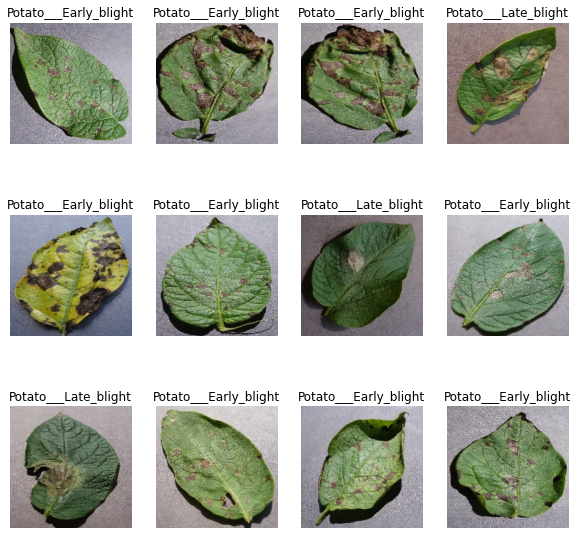

In [ ]:
plt.figure(figsize = (10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [ ]:
# train => 80 / vali => 10 / test => 10
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle= True, shuffle_size = 10000 ):
  assert(train_split + test_split + val_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(ds_size*train_split)
  val_size = int(ds_size*val_split)

  train_ds = ds.take(train_size)
  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
# CACHE, SHUFFLE & PREFETCH the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model

In [ ]:
# Creating a layers for Resizing and Normalization

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
# Data augmentaion

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
# Applying data sugmentaion to train dataset

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)



# Model Architecture

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size = (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [ ]:
#complie the Model
model.compile(
    optimizer = 'adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 275s 403ms/step - loss: 0.9048 - accuracy: 0.4624 - val_loss: 0.9010 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 17s 314ms/step - loss: 0.7592 - accuracy: 0.6094 - val_loss: 0.5769 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 16s 303ms/step - loss: 0.5239 - accuracy: 0.7610 - val_loss: 0.3743 - val_accuracy: 0.8438
Epoch 4/50
54/54 [==============================] - 17s 305ms/step - loss: 0.3646 - accuracy: 0.8403 - val_loss: 0.5314 - val_accuracy: 0.8021
Epoch 5/50
54/54 [==============================] - 17s 306ms/step - loss: 0.3141 - accuracy: 0.8773 - val_loss: 0.2895 - val_accuracy: 0.9010
Epoch 6/50
54/54 [==============================] - 17s 306ms/step - loss: 0.2438 - accuracy: 0.9097 - val_loss: 0.1791 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 17s 314ms/step - loss: 0.2222 - accuracy: 0.9132 - val_loss: 0.2433 - val_accuracy: 0.901

In [ ]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 5s 47ms/step - loss: 0.0630 - accuracy: 0.9844


[0.06300315260887146, 0.984375]

# Plotting the Accuracy and Loss Curves

In [ ]:
history.history.keys()
# all four values are list in itself

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# type(history.history['loss'])
# len(history.history['loss'])
history.history['loss'][:5] # show loss for first 5 epochs

[0.9047508239746094,
 0.7592028975486755,
 0.5239080190658569,
 0.36462515592575073,
 0.31413862109184265]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

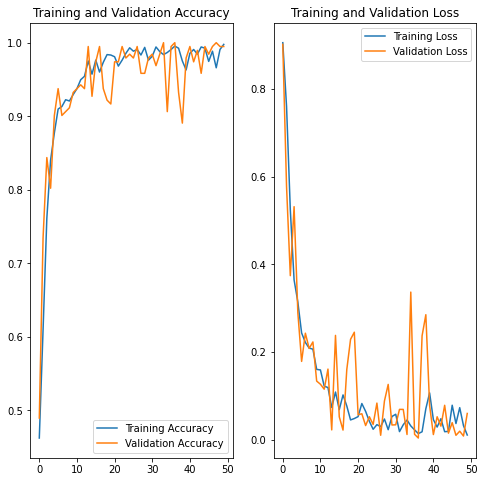

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Run Prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


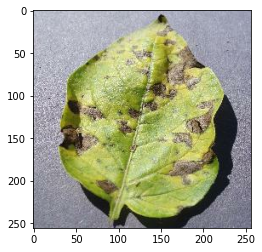

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  print("actual label:",class_names[first_label])
  batch_prediction = model.predict(images_batch)
  print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Inference & check

In [ ]:
def predict(model,img):
  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_array = tf.expand_dims(img_array,0)

  predictions = model.predict(img_array)
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100*(np.max(predictions[0])), 2)
  return predicted_class, confidence

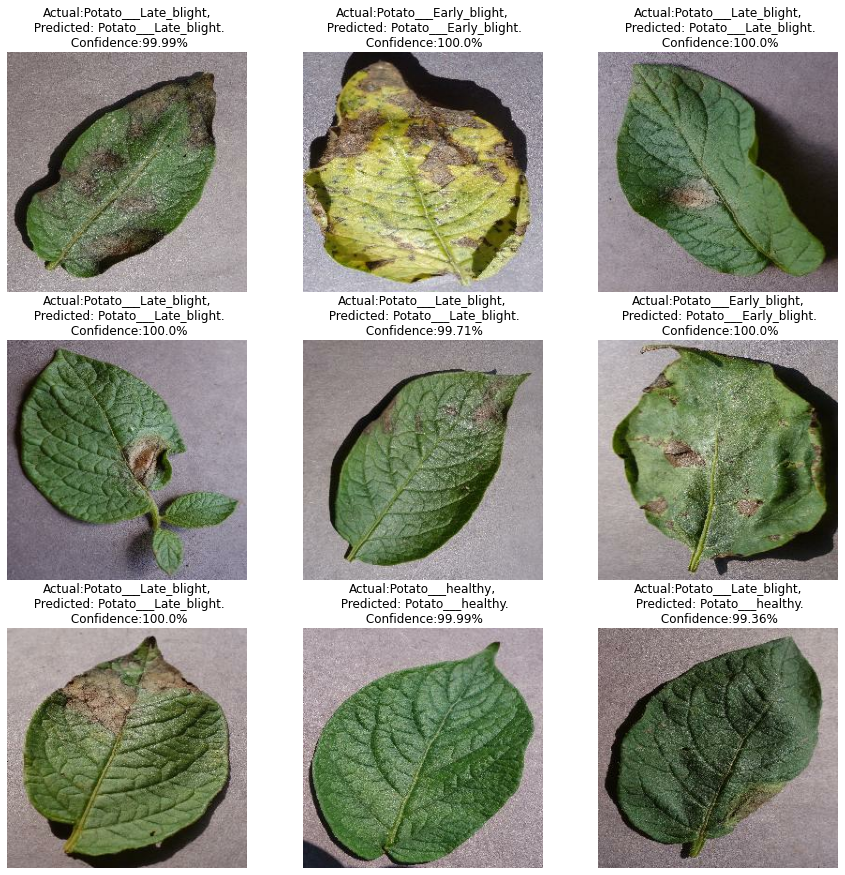

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]
    plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence:{confidence}%")
    plt.axis("off") 

# Saving the model

In [ ]:
!mkdir saved_model

In [ ]:
!ls

PlantVillage  plant-village.zip  potatoes.h5  saved_model  training


In [ ]:
# model_version = 1
# model.save(f"model/{model_version}")

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("saved_model") + [0]])+1 #next model version
model.save(f"saved_model/{model_version}")

INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
model.save("potatoes.h5")